<a href="https://colab.research.google.com/github/VegaSera/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/Wesley_Mountford_LS_DS12_233_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###This is a continuation of yesterday's assignment notebook. 
Everything for today's assignment will be towards the bottom of the notebook.

In [0]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import requests
import os, sys

In [2]:
!pip install eli5

In [0]:
def extract_class_data(filename, stsclass=None):
  data = json.load(open(filename))
  data = json_normalize(data=data)
  df = pd.DataFrame(data=data)
  df.columns = [i.replace('event.', '') for i in df.columns]

  if stsclass is not None: #If a class is specified, returns a dataframe with only that class.
    df = df[df['character_chosen'] == stsclass]

  df = df[(df['chose_seed'] == False) & (df['is_endless'] == False)] #Always dropping seeded and endless runs.

  return df

In [0]:
# stsclass = 'IRONCLAD' #The class we're trying to predict


# #Setting up an initial file to append new stuff to.
# initial_file = 'data/2018-10-25-02-34#1352.json'
# dat = json.load(open(initial_file))
# dat = json_normalize(data=dat)
# stsdf= pd.DataFrame(data=dat)
# stsdf.columns = [i.replace('event.', '') for i in stsdf.columns]
# stsdf = stsdf[stsdf['character_chosen'] == stsclass]
# stsdf = stsdf[(stsdf['chose_seed'] == False) & (stsdf['is_endless'] == False)]
# stsdf.head(3)

In [0]:
# num=0
# file_length = len([i for i in os.listdir('data/')])
# for file in os.listdir('data/'):
#   stsdf = stsdf.append(extract_class_data(f'data/{file}', stsclass), sort=False, ignore_index=True)
#   num += 1
#   print(f'{file} done, {num}/{file_length}') #Takes a couple minutes, progress monitor was necessary
# stsdf.reset_index()
# stsdf

In [0]:
#stsdf.to_csv('sts_ironclad_59319.csv')

In [0]:
#stsdf.master_deck[1542]

In [3]:
stsdf = pd.read_csv('sts_ironclad_59319.csv') #Once we have our file ready, we can read it in directly rather than build it from several JSONs. Faster to get back up and running when the runtime expires

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,19,28,29,30,37,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df2 = stsdf[['master_deck', 'relics', 'ascension_level', 'victory']].copy()
df2 = df2.dropna()
df2
#Now we need to encode these cards and relics into their own column.

,master_deck,relics,ascension_level,victory
0,"['Strike_R', 'Strike_R', 'Strike_R', 'Strike_R...",['Burning Blood'],20.0,False
1,"['Defend_R', 'Defend_R', 'Defend_R+1', 'Defend...","['Burning Blood', 'War Paint', 'Dream Catcher'...",2.0,False
2,"['Strike_R+1', 'Strike_R', 'Strike_R', 'Strike...","['Burning Blood', 'Regal Pillow', 'Art of War']",10.0,False
3,"['Strike_R', 'Strike_R', 'Strike_R', 'Strike_R...","['Burning Blood', 'Oddly Smooth Stone', 'Smili...",20.0,False
4,"['Strike_R', 'Strike_R', 'Strike_R', 'Strike_R...","['Burning Blood', 'Oddly Smooth Stone', 'Dodec...",0.0,False
...,...,...,...,...
24845,"['Strike_R', 'Strike_R', 'Defend_R', 'Defend_R...","['Burning Blood', 'Dream Catcher', 'Peace Pipe...",1.0,False
24846,"['Strike_R', 'Strike_R', 'Strike_R', 'Strike_R...","['Burning Blood', 'Pen Nib', 'StoneCalendar', ...",7.0,True
24847,"['Strike_R', 'Strike_R', 'Strike_R', 'Defend_R...","['Black Blood', 'NeowsBlessing', 'Red Skull', ...",20.0,False
24848,"['Strike_R', 'Strike_R+1', 'Strike_R', 'Strike...","['Burning Blood', 'NeowsBlessing', 'Pear', 'Ma...",8.0,False


In [0]:
#Now we need to write a function that takes the string for each entry and turns it into a list.
def listify(string):
  '''
  Takes a string in a specific format, such as "['Burning Blood', 'War Paint', 'Dream Catcher', 'Regal Pillow', 'Mark of Pain', 'Shovel', 'Omamori']"
  Removes the brackets, spaces, and quotes, and returns a list.
  '''
  new_string = string.replace('[', '').replace(']', '').replace("'","").replace(" ","_").replace(",_", ",")
  #First two replaces get rid of brackets. Third gets rid of quotes. Fourth replaces whitespace with underscores, fifth removes leading underscores.
  newlist = new_string.split(",") #Splits the string and creates a proper list.
  return newlist

In [6]:
df2.relics = df2.relics.apply(listify)
df2.master_deck = df2.master_deck.apply(listify)
df2

,master_deck,relics,ascension_level,victory
0,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",[Burning_Blood],20.0,False
1,"[Defend_R, Defend_R, Defend_R+1, Defend_R+1, B...","[Burning_Blood, War_Paint, Dream_Catcher, Rega...",2.0,False
2,"[Strike_R+1, Strike_R, Strike_R, Strike_R, Def...","[Burning_Blood, Regal_Pillow, Art_of_War]",10.0,False
3,"[Strike_R, Strike_R, Strike_R, Strike_R, Defen...","[Burning_Blood, Oddly_Smooth_Stone, Smiling_Ma...",20.0,False
4,"[Strike_R, Strike_R, Strike_R, Strike_R, Defen...","[Burning_Blood, Oddly_Smooth_Stone, Dodecahedr...",0.0,False
...,...,...,...,...
24845,"[Strike_R, Strike_R, Defend_R, Defend_R, Defen...","[Burning_Blood, Dream_Catcher, Peace_Pipe, Bla...",1.0,False
24846,"[Strike_R, Strike_R, Strike_R, Strike_R, Defen...","[Burning_Blood, Pen_Nib, StoneCalendar, Incens...",7.0,True
24847,"[Strike_R, Strike_R, Strike_R, Defend_R, Defen...","[Black_Blood, NeowsBlessing, Red_Skull, Pear, ...",20.0,False
24848,"[Strike_R, Strike_R+1, Strike_R, Strike_R, Str...","[Burning_Blood, NeowsBlessing, Pear, Mark_of_P...",8.0,False


In [7]:
#Now we can use this to get a full list of our cards, and likewise for our relics by substituting in relics where master_deck is.
set(df2.master_deck.sum())
#This presents a slight problem. There are several cards here that are from other classes via Prismatic Shard. 
#We can either accept this, or attempt to filter out the runs that have a prismatic shard.

{'A_Thousand_Cuts',
 'A_Thousand_Cuts+1',
 'Accuracy+1',
 'Acrobatics',
 'Acrobatics+1',
 'Adrenaline',
 'Adrenaline+1',
 'After_Image',
 'Aggregate',
 'Aggregate+1',
 'All_For_One',
 'All_For_One+1',
 'All_Out_Attack+1',
 'Anger',
 'Anger+1',
 'Apotheosis',
 'Apotheosis+1',
 'Armaments',
 'Armaments+1',
 'AscendersBane',
 'Auto_Shields',
 'Auto_Shields+1',
 'Backflip',
 'Backflip+1',
 'Backstab',
 'Backstab+1',
 'Ball_Lightning',
 'Ball_Lightning+1',
 'Bandage_Up',
 'Bandage_Up+1',
 'Bane+1',
 'Barrage+1',
 'Barricade',
 'Barricade+1',
 'Bash',
 'Bash+1',
 'Battle_Trance',
 'Battle_Trance+1',
 'Beam_Cell',
 'Beam_Cell+1',
 'Berserk',
 'Berserk+1',
 'Bite',
 'Bite+1',
 'Blade_Dance',
 'Blade_Dance+1',
 'Blind',
 'Blind+1',
 'Blood_for_Blood',
 'Blood_for_Blood+1',
 'Bloodletting',
 'Bloodletting+1',
 'Bludgeon',
 'Bludgeon+1',
 'Blur',
 'Blur+1',
 'Body_Slam',
 'Body_Slam+1',
 'BootSequence',
 'BootSequence+1',
 'Brutality',
 'Brutality+1',
 'Buffer',
 'Bullet_Time',
 'Burning_Pact',
 

In [0]:
#If we accept prismatic shard and it's consequences, then we will have this many extra columns:
col_length = len(set(df2.relics.sum())) + len(set(df2.master_deck.sum()))
print(f'Total number of columns = {col_length}')
#613 extra columns total.
#Removing prismatic shard and the ability to get cards from other classes may cut this number close to in half.

Total number of columns = 613


In [0]:
df2.victory.value_counts(normalize=True)

False    0.888974
True     0.111026
Name: victory, dtype: float64

#Note to TL regarding this assignment:

This assignment had three criteria:
- [x] Continue to clean and explore your data. 
- [X] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

As you could see above, I am still working on the cleaning and the engineering. Focus was difficult again, but I remain confident that I will have everything done in time. I have not been wrong about this yet.

The score I would get by guessing the majority is 88.8% with the above total, assuming I'm always guessing failure.

I have not got a model yet.

## What's next

Next up is getting the complete list of cards and relics (similar to how I did when combining their lengths), and then adding new columns for each, set at a default of 0.

Then we go row by row, checking to see if any values need to be added to our new columns.

After which we will be good to start our first model.

---

I anticipate that this initial model may be too complex with the addition of Prismatic Shard and the other class cards, or perhaps not very indicative of the ironclad class alone, however it should be possible to get rid of *most* of the other class cards just by filtering out prismatic shard. This may be easier to do after setting our columns.

In [0]:
df3 = df2.copy()

#Setting up our column names. Column names must be unique and identify if it's a card or relic
deck_list = list(set(df3.master_deck.sum()))
relic_list = list(set(df3.relics.sum()))

deck_list = ["CARD_" + s for s in deck_list]
relic_list = ["RELIC_" + s for s in relic_list]

In [0]:
total_list = deck_list + relic_list #Combines decks and relics for our total list of new columns.

In [10]:
for col in total_list: #Adds all of our new columns, and sets the value in every row to 0. We will fix this in the next step.
  df3[col] = pd.Series([0 for x in range(len(df3))])
df3.head()

,master_deck,relics,ascension_level,victory,CARD_Doom_and_Gloom+1,CARD_Rip_and_Tear,CARD_Flame_Barrier+1,CARD_Pommel_Strike+1,CARD_Uppercut+1,CARD_Footwork,CARD_Regret,CARD_Trip,CARD_Berserk+1,CARD_Chaos,CARD_Conserve_Battery+1,CARD_Magnetism+1,CARD_Parasite,CARD_Dodge_and_Roll,CARD_Seek,CARD_Conserve_Battery,CARD_Backflip+1,CARD_Storm,CARD_Intimidate+1,CARD_Good_Instincts,CARD_Writhe,CARD_Metallicize+1,CARD_Accuracy+1,CARD_Infinite_Blades+1,CARD_Pain,CARD_Evolve,CARD_Strike_B,CARD_Body_Slam,CARD_Searing_Blow+8,CARD_Madness,CARD_Battle_Trance+1,CARD_Anger,CARD_Dagger_Throw+1,CARD_Searing_Blow+5,CARD_Bludgeon,CARD_Mayhem,...,RELIC_FossilizedHelix,RELIC_Du-Vu_Doll,RELIC_Frozen_Egg_2,RELIC_Pantograph,RELIC_Velvet_Choker,RELIC_Lantern,RELIC_Darkstone_Periapt,RELIC_Shuriken,RELIC_Old_Coin,RELIC_Bag_of_Marbles,RELIC_Gambling_Chip,RELIC_Meat_on_the_Bone,RELIC_Necronomicon,RELIC_Bird_Faced_Urn,RELIC_Toy_Ornithopter,RELIC_Circlet,RELIC_Singing_Bowl,RELIC_Tiny_Chest,RELIC_Black_Star,RELIC_Dream_Catcher,RELIC_MutagenicStrength,RELIC_Pocketwatch,RELIC_Sozu,RELIC_Sling,RELIC_Orrery,RELIC_Red_Mask,RELIC_Mummified_Hand,RELIC_Dodecahedron,RELIC_Happy_Flower,RELIC_Whetstone,RELIC_Magic_Flower,"RELIC_""Pandoras_Box""",RELIC_Oddly_Smooth_Stone,RELIC_Ectoplasm,RELIC_Orichalcum,RELIC_Champion_Belt,RELIC_Nunchaku,RELIC_Art_of_War,RELIC_Unceasing_Top,RELIC_Prayer_Wheel
0,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",[Burning_Blood],20.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[Defend_R, Defend_R, Defend_R+1, Defend_R+1, B...","[Burning_Blood, War_Paint, Dream_Catcher, Rega...",2.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"[Strike_R+1, Strike_R, Strike_R, Strike_R, Def...","[Burning_Blood, Regal_Pillow, Art_of_War]",10.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"[Strike_R, Strike_R, Strike_R, Strike_R, Defen...","[Burning_Blood, Oddly_Smooth_Stone, Smiling_Ma...",20.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"[Strike_R, Strike_R, Strike_R, Strike_R, Defen...","[Burning_Blood, Oddly_Smooth_Stone, Dodecahedr...",0.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
for index, row in df3.iterrows():
  for card in row[0]:
    df3.at[index, ('CARD_'+card)] = 1
  for relic in row[1]:
    df3.at[index, ('RELIC_'+relic)] = 1
df3.head()

,master_deck,relics,ascension_level,victory,CARD_Doom_and_Gloom+1,CARD_Rip_and_Tear,CARD_Flame_Barrier+1,CARD_Pommel_Strike+1,CARD_Uppercut+1,CARD_Footwork,CARD_Regret,CARD_Trip,CARD_Berserk+1,CARD_Chaos,CARD_Conserve_Battery+1,CARD_Magnetism+1,CARD_Parasite,CARD_Dodge_and_Roll,CARD_Seek,CARD_Conserve_Battery,CARD_Backflip+1,CARD_Storm,CARD_Intimidate+1,CARD_Good_Instincts,CARD_Writhe,CARD_Metallicize+1,CARD_Accuracy+1,CARD_Infinite_Blades+1,CARD_Pain,CARD_Evolve,CARD_Strike_B,CARD_Body_Slam,CARD_Searing_Blow+8,CARD_Madness,CARD_Battle_Trance+1,CARD_Anger,CARD_Dagger_Throw+1,CARD_Searing_Blow+5,CARD_Bludgeon,CARD_Mayhem,...,RELIC_FossilizedHelix,RELIC_Du-Vu_Doll,RELIC_Frozen_Egg_2,RELIC_Pantograph,RELIC_Velvet_Choker,RELIC_Lantern,RELIC_Darkstone_Periapt,RELIC_Shuriken,RELIC_Old_Coin,RELIC_Bag_of_Marbles,RELIC_Gambling_Chip,RELIC_Meat_on_the_Bone,RELIC_Necronomicon,RELIC_Bird_Faced_Urn,RELIC_Toy_Ornithopter,RELIC_Circlet,RELIC_Singing_Bowl,RELIC_Tiny_Chest,RELIC_Black_Star,RELIC_Dream_Catcher,RELIC_MutagenicStrength,RELIC_Pocketwatch,RELIC_Sozu,RELIC_Sling,RELIC_Orrery,RELIC_Red_Mask,RELIC_Mummified_Hand,RELIC_Dodecahedron,RELIC_Happy_Flower,RELIC_Whetstone,RELIC_Magic_Flower,"RELIC_""Pandoras_Box""",RELIC_Oddly_Smooth_Stone,RELIC_Ectoplasm,RELIC_Orichalcum,RELIC_Champion_Belt,RELIC_Nunchaku,RELIC_Art_of_War,RELIC_Unceasing_Top,RELIC_Prayer_Wheel
0,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",[Burning_Blood],20.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[Defend_R, Defend_R, Defend_R+1, Defend_R+1, B...","[Burning_Blood, War_Paint, Dream_Catcher, Rega...",2.0,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"[Strike_R+1, Strike_R, Strike_R, Strike_R, Def...","[Burning_Blood, Regal_Pillow, Art_of_War]",10.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,"[Strike_R, Strike_R, Strike_R, Strike_R, Defen...","[Burning_Blood, Oddly_Smooth_Stone, Smiling_Ma...",20.0,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,"[Strike_R, Strike_R, Strike_R, Strike_R, Defen...","[Burning_Blood, Oddly_Smooth_Stone, Dodecahedr...",0.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [12]:
df3.describe()

,ascension_level,CARD_Uppercut+1,CARD_Searing_Blow+3,CARD_Strike_R+1,CARD_Carnage+1,CARD_Demon_Form+1,CARD_Reboot,CARD_Rip_and_Tear,CARD_Reckless_Charge,CARD_Melter+1,CARD_Body_Slam,CARD_Seek+1,CARD_Madness,CARD_Corruption,CARD_All_Out_Attack+1,CARD_Bash+1,CARD_Immolate+1,CARD_Chaos+1,CARD_Deadly_Poison,CARD_Steam+1,CARD_Armaments+1,CARD_Streamline+1,CARD_Impatience+1,CARD_Demon_Form,CARD_Footwork,CARD_HandOfGreed,CARD_Body_Slam+1,CARD_Impervious+1,CARD_Dark_Embrace,CARD_Dagger_Spray,CARD_Melter,CARD_Rainbow,CARD_Bullet_Time,CARD_Shockwave+1,CARD_Dual_Wield,CARD_Battle_Trance+1,CARD_Hyperbeam,CARD_Offering+1,CARD_Iron_Wave+1,CARD_Fiend_Fire+1,...,RELIC_Bag_of_Marbles,RELIC_Omamori,RELIC_Potion_Belt,RELIC_Tough_Bandages,RELIC_TheAbacus,RELIC_Lantern,RELIC_Strange_Spoon,RELIC_White_Beast_Statue,RELIC_Bloody_Idol,RELIC_Centennial_Puzzle,RELIC_Tiny_House,"RELIC_""Lees_Waffle""",RELIC_Frozen_Egg_2,RELIC_WarpedTongs,RELIC_Nunchaku,RELIC_Pen_Nib,RELIC_Runic_Dome,RELIC_HandDrill,RELIC_Cursed_Key,RELIC_Coffee_Dripper,RELIC_War_Paint,RELIC_Magic_Flower,RELIC_Blood_Vial,RELIC_Runic_Cube,RELIC_Ectoplasm,RELIC_Snecko_Eye,RELIC_GremlinMask,RELIC_Mark_of_Pain,RELIC_Oddly_Smooth_Stone,RELIC_Bag_of_Preparation,RELIC_Brimstone,RELIC_NeowsBlessing,RELIC_Mango,RELIC_Orrery,RELIC_Molten_Egg_2,RELIC_Champion_Belt,RELIC_Shovel,RELIC_Paper_Frog,RELIC_Toolbox,RELIC_DollysMirror
count,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,...,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.00000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000,24850.000000
mean,7.401247,0.066036,0.006076,0.226962,0.037586,0.074849,0.000121,0.000040,0.022455,0.000080,0.061851,0.000121,0.031107,0.024748,0.000080,0.287807,0.037344,0.000121,0.000161,0.000121,0.202294,0.000241,0.001891,0.076097,0.000282,0.003179,0.089215,0.022254,0.017344,0.000241,0.000201,0.000040,0.000080,0.058270,0.039799,0.054487,0.000121,0.045111,0.074930,0.021529,...,0.109497,0.094527,0.093682,0.000040,0.006036,0.108934,0.005755,0.025070,0.012877,0.095614,0.034648,0.019316,0.075734,0.033521,0.037867,0.105956,0.017062,0.011670,0.056137,0.024909,0.10507,0.036861,0.098310,0.023903,0.018753,0.016821,0.010463,0.047847,0.106841,0.100523,0.015533,0.221207,0.034769,0.036861,0.080201,0.038068,0.034769,0.079839,0.009658,0.014688
std,7.024257,0.248350,0.077716,0.418876,0.190195,0.263153,0.010987,0.006344,0.148160,0.008971,0.240890,0.010987,0.173609,0.155361,0.008971,0.452750,0.189607,0.010987,0.012686,0.010987,0.401718,0.015537,0.043449,0.265158,0.016782,0.056295,0.285060,0.147510,0.130552,0.015537,0.014184,0.006344,0.008971,0.234257,0.195490,0.226981,0.010987,0.207551,0.263283,0.145143,...,0.312268,0.292567,0.291392,0.006344,0.077460,0.311562,0.075642,0.156342,0.112747,0.294067,0.182890,0.137636,0.264578,0.179997,0.190879,0.307787,0.129506,0.107398,0.230190,0.155852,0.30665,0.188425,0.297739,0.152751,0.135652,0.128603,0.101753,0.213447,0.308917,0.300702,0.123663,0.415068,0.183197,0.188425,0.271610,0.191365,0.183197,0.271049,0.097801,0.120304
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [12]:
df3 = df3[df3['RELIC_PrismaticShard'] == 0]
for col in df3.columns[2:]: #Cannot pass columns with lists into the next line. Slicing those out.
  if len(df3[col].unique()) == 1:
    df3 = df3.drop(col, axis=1)
df3.columns

Index(['master_deck', 'relics', 'ascension_level', 'victory',
       'CARD_Flame_Barrier+1', 'CARD_Pommel_Strike+1', 'CARD_Uppercut+1',
       'CARD_Regret', 'CARD_Trip', 'CARD_Berserk+1',
       ...
       'RELIC_Magic_Flower', 'RELIC_"Pandoras_Box"',
       'RELIC_Oddly_Smooth_Stone', 'RELIC_Ectoplasm', 'RELIC_Orichalcum',
       'RELIC_Champion_Belt', 'RELIC_Nunchaku', 'RELIC_Art_of_War',
       'RELIC_Unceasing_Top', 'RELIC_Prayer_Wheel'],
      dtype='object', length=408)

In [14]:
df3.describe()

,ascension_level,CARD_Uppercut+1,CARD_Searing_Blow+3,CARD_Strike_R+1,CARD_Carnage+1,CARD_Demon_Form+1,CARD_Reckless_Charge,CARD_Body_Slam,CARD_Madness,CARD_Corruption,CARD_Bash+1,CARD_Immolate+1,CARD_Armaments+1,CARD_Impatience+1,CARD_Demon_Form,CARD_HandOfGreed,CARD_Body_Slam+1,CARD_Impervious+1,CARD_Dark_Embrace,CARD_Shockwave+1,CARD_Dual_Wield,CARD_Battle_Trance+1,CARD_Offering+1,CARD_Iron_Wave+1,CARD_Fiend_Fire+1,CARD_Exhume,CARD_Entrench,CARD_Bandage_Up+1,CARD_Bite,CARD_Regret,CARD_Doubt,CARD_Shockwave,CARD_Thunderclap,CARD_Armaments,CARD_Magnetism,CARD_Power_Through,CARD_Metamorphosis,CARD_Clothesline+1,CARD_Burning_Pact+1,CARD_Whirlwind,...,RELIC_Bag_of_Marbles,RELIC_Omamori,RELIC_Potion_Belt,RELIC_Tough_Bandages,RELIC_TheAbacus,RELIC_Lantern,RELIC_Strange_Spoon,RELIC_White_Beast_Statue,RELIC_Bloody_Idol,RELIC_Centennial_Puzzle,RELIC_Tiny_House,"RELIC_""Lees_Waffle""",RELIC_Frozen_Egg_2,RELIC_WarpedTongs,RELIC_Nunchaku,RELIC_Pen_Nib,RELIC_Runic_Dome,RELIC_HandDrill,RELIC_Cursed_Key,RELIC_Coffee_Dripper,RELIC_War_Paint,RELIC_Magic_Flower,RELIC_Blood_Vial,RELIC_Runic_Cube,RELIC_Ectoplasm,RELIC_Snecko_Eye,RELIC_GremlinMask,RELIC_Mark_of_Pain,RELIC_Oddly_Smooth_Stone,RELIC_Bag_of_Preparation,RELIC_Brimstone,RELIC_NeowsBlessing,RELIC_Mango,RELIC_Orrery,RELIC_Molten_Egg_2,RELIC_Champion_Belt,RELIC_Shovel,RELIC_Paper_Frog,RELIC_Toolbox,RELIC_DollysMirror
count,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,...,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000,24559.000000
mean,7.416466,0.066249,0.006108,0.226719,0.037664,0.074352,0.022354,0.061647,0.030905,0.024675,0.287064,0.037094,0.201555,0.001792,0.076469,0.003054,0.088929,0.022110,0.017305,0.058064,0.039619,0.054074,0.044587,0.074759,0.021296,0.031312,0.027444,0.005578,0.022599,0.044261,0.051631,0.057861,0.164095,0.101918,0.004235,0.040393,0.004764,0.047559,0.018527,0.075044,...,0.109084,0.093652,0.093082,0.000041,0.005904,0.108311,0.005456,0.025082,0.012908,0.094996,0.034122,0.019178,0.075044,0.033226,0.037339,0.104565,0.016980,0.011442,0.055580,0.024594,0.104483,0.036361,0.097642,0.023494,0.018568,0.016613,0.010505,0.047600,0.106112,0.099963,0.015310,0.221467,0.034448,0.036565,0.079808,0.037746,0.034814,0.079360,0.009447,0.014292
std,7.031726,0.248721,0.077915,0.418718,0.190387,0.262347,0.147836,0.240519,0.173064,0.155137,0.452401,0.188997,0.401170,0.042290,0.265752,0.055179,0.284647,0.147044,0.130409,0.233870,0.195066,0.226168,0.206398,0.263007,0.144371,0.174164,0.163377,0.074482,0.148623,0.205678,0.221285,0.233485,0.370369,0.302546,0.064938,0.196882,0.068859,0.212835,0.134849,0.263467,...,0.311751,0.291350,0.290553,0.006381,0.076613,0.310779,0.073666,0.156379,0.112879,0.293215,0.181546,0.137154,0.263467,0.179230,0.189594,0.305998,0.129197,0.106355,0.229114,0.154887,0.305892,0.187192,0.296837,0.151471,0.134995,0.127819,0.101958,0.212922,0.307987,0.299957,0.122786,0.415242,0.182380,0.187695,0.271001,0.190585,0.183312,0.270305,0.096736,0.118695
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [0]:
df3.victory = df3.victory.astype(bool)

#First Model



In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df3.drop(['master_deck', 'relics'], axis=1), test_size = 0.2)
train, val = train_test_split(train, test_size = 0.2)

train.shape, val.shape, test.shape

((15717, 406), (3930, 406), (4912, 406))

In [0]:
target = 'victory'

x_train = train.drop(columns=target)
y_train = train[target]
x_val = val.drop(columns=target)
y_val = val[target]
x_test = test.drop(columns=target)
y_test = test[target]

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

In [19]:
model = RandomForestClassifier()

params = {
    'n_estimators' : [50, 75, 100, 150, 250],
    'min_samples_leaf' : [1, 2, 3, 4, 5]
}

search = RandomizedSearchCV(model, param_distributions=params, n_iter=50, cv=7, scoring='accuracy', verbose=10, return_train_score=True, n_jobs=-1)

search.fit(x_train, y_train)

Fitting 7 folds for each of 25 candidates, totalling 175 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a m

RandomizedSearchCV(cv=7, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [20]:
print('Best hyperparameters', search.best_params_)
print('Best Model Accuracy', search.best_score_)
#90.5% does beat our baseline, but not by a ton.

Best hyperparameters {'n_estimators': 50, 'min_samples_leaf': 1}
Best Model Accuracy 0.9041163716228716


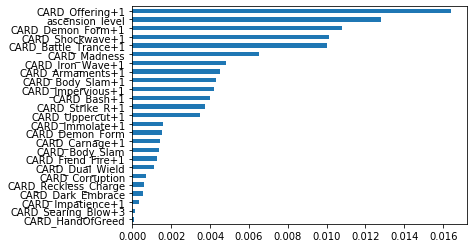

In [21]:
columns = x_val.columns
importances = pd.Series(search.best_estimator_.feature_importances_, columns)
importances[0:25].sort_values().plot.barh()
#Ran this multiple times with different train/validation splits, and the top cards seem to change. May have to go to a larger dataset.

#It looks like ascension level is by far the best indicator of success.
#This may be counterintuitive at first considering ascension level drastically increases the difficulty, however the most experienced players play on high ascensions.

##Permutation Importances with the random forest classifier

In [19]:
model = RandomForestClassifier(n_estimators=50)

model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5
)

permuter.fit(x_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [21]:
feature_names = x_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

RELIC_Whetstone        -0.000458
RELIC_Tiny_Chest       -0.000407
RELIC_Pen_Nib          -0.000356
CARD_Thunderclap+1     -0.000356
RELIC_MawBank          -0.000356
                          ...   
CARD_Battle_Trance+1    0.002036
CARD_Strike_R           0.002087
CARD_Shrug_It_Off+1     0.002799
CARD_Offering+1         0.003308
RELIC_Red_Mask          0.003766
Length: 405, dtype: float64

In [22]:
eli5.show_weights(
    permuter, 
    top=40,
    feature_names=feature_names
)
#It seems like our top features are constantly in flux. I believe will need to go to a larger dataset than we currently have, which will take a few hours.

Weight,Feature
0.0038 ± 0.0014,RELIC_Red_Mask
0.0033 ± 0.0010,CARD_Offering+1
0.0028 ± 0.0012,CARD_Shrug_It_Off+1
0.0021 ± 0.0009,CARD_Strike_R
0.0020 ± 0.0009,CARD_Battle_Trance+1
0.0019 ± 0.0008,CARD_Limit_Break+1
0.0018 ± 0.0008,RELIC_Vajra
0.0016 ± 0.0010,CARD_Bash
0.0015 ± 0.0007,RELIC_War_Paint
0.0015 ± 0.0002,CARD_Bash+1


#Applying XGBoost instead of RandomForest.

In [17]:
from xgboost import XGBClassifier

model2 = XGBClassifier(n_estimators=100)


model2.fit(x_train, y_train)

#Attempted to use XGBClassifier with the features present in the lecture notebook, 
#but it would crash without an error every time.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [18]:
from sklearn.metrics import accuracy_score
y_pred = model2.predict(x_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))
#94% is not bad at all.

Validation Accuracy 0.9409669211195929


In [23]:
#Need to make sure my 94% isn't a fluke.
y2_pred = model2.predict(x_test)
print('Test Accuracy', accuracy_score(y_test, y2_pred))

Validation Accuracy 0.942385993485342


In [24]:
permuter = PermutationImportance(
    model2,
    scoring='accuracy',
    n_iter=5
)

permuter.fit(x_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=1000, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                    

In [25]:
eli5.show_weights(
    permuter, 
    top=40,
    feature_names=feature_names
)

Weight,Feature
0.0041 ± 0.0013,RELIC_Cursed_Key
0.0039 ± 0.0027,ascension_level
0.0033 ± 0.0006,CARD_Limit_Break+1
0.0028 ± 0.0014,RELIC_Busted_Crown
0.0027 ± 0.0015,RELIC_Velvet_Choker
0.0021 ± 0.0012,CARD_Offering+1
0.0020 ± 0.0009,RELIC_Anchor
0.0019 ± 0.0010,CARD_Inflame+1
0.0017 ± 0.0012,CARD_Sword_Boomerang+1
0.0017 ± 0.0010,RELIC_FossilizedHelix
